In [2]:

!pip install -q seaborn scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa, librosa.display
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             adjusted_rand_score, normalized_mutual_info_score)
from scipy.optimize import linear_sum_assignment



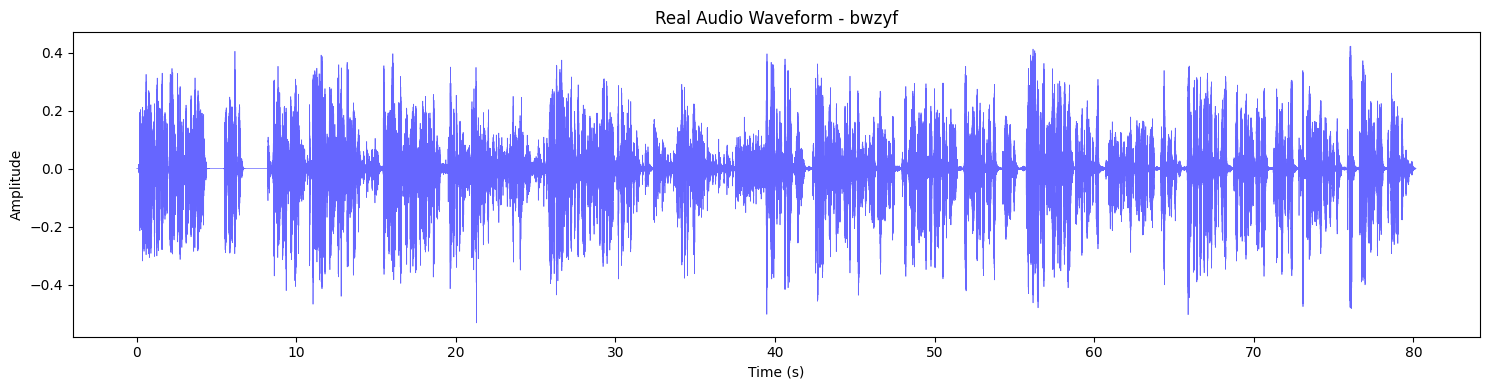

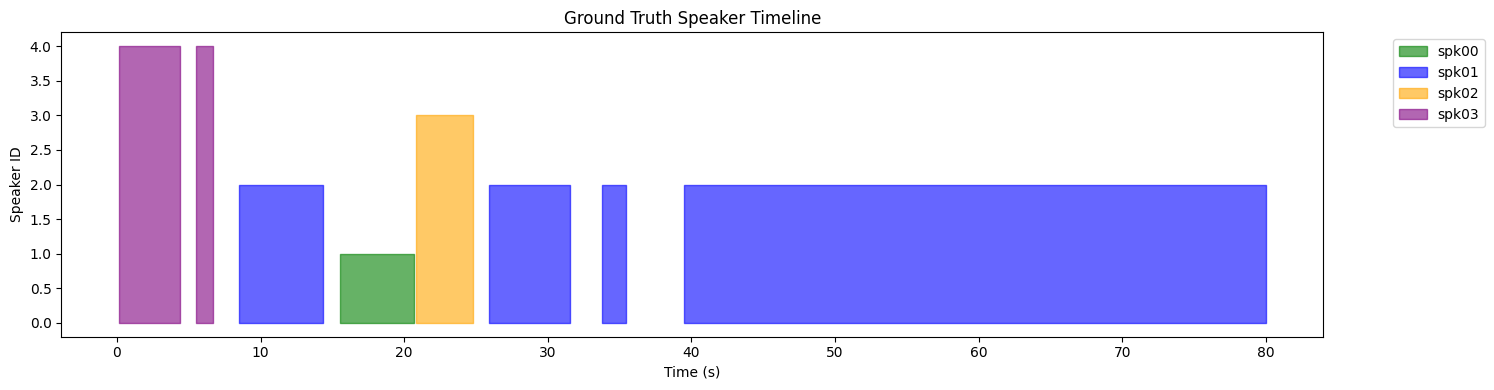

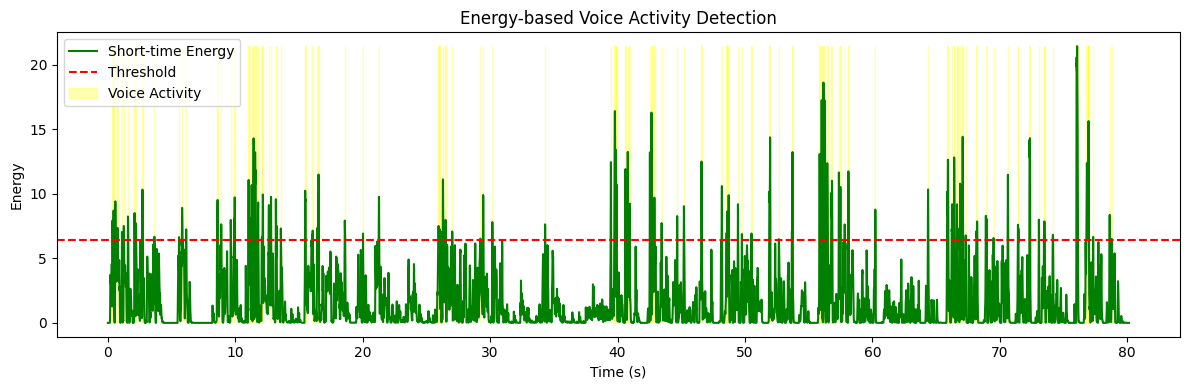

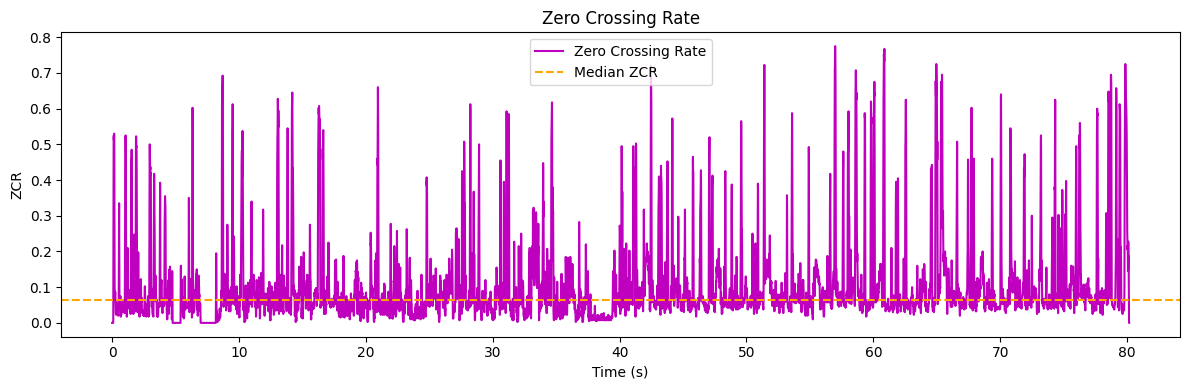

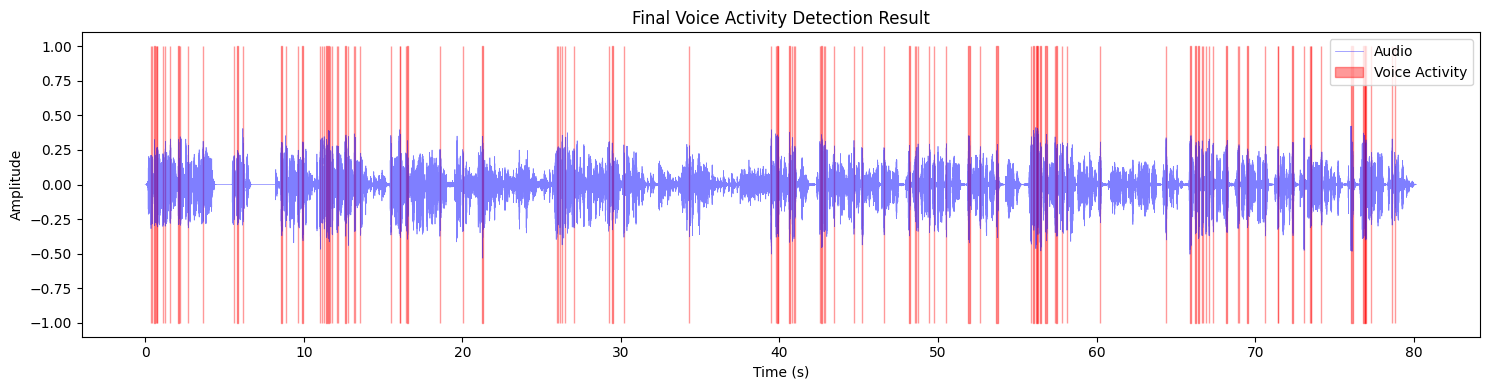

✅ All plots saved to /kaggle/working/


In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# === Parameters ===
dataset_path = "/kaggle/input/voxconverse-dataset"
file_id = "bwzyf"
sr = 16000

# === Load audio ===
audio_path = Path(dataset_path) / "voxconverse_dev_wav" / "audio" / f"{file_id}.wav"
audio, _ = librosa.load(audio_path, sr=sr)
time = np.arange(len(audio)) / sr

# === Parse RTTM ===
def parse_rttm(rttm_file):
    segments = []
    with open(rttm_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 8 and parts[0] == 'SPEAKER':
                start = float(parts[3])
                dur = float(parts[4])
                end = start + dur
                spk = parts[7]
                segments.append((start, end, spk))
    return segments

rttm_file = Path(dataset_path) / "labels" / "dev" / f"{file_id}.rttm"
segments = parse_rttm(rttm_file)

# === 1. Real Audio Waveform ===
plt.figure(figsize=(15, 4))
plt.plot(time, audio, color="blue", alpha=0.6, linewidth=0.5)
plt.title(f"Real Audio Waveform - {file_id}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.savefig(f"/kaggle/working/{file_id}_waveform.png", dpi=300)
plt.show()

# === 2. Ground Truth Timeline ===
plt.figure(figsize=(15, 4))
colors = ["red", "green", "blue", "orange", "purple"]
spk_map = {spk: idx+1 for idx, spk in enumerate(sorted(set(s for _,_,s in segments)))}
for start, end, spk in segments:
    plt.fill_between([start, end], 0, spk_map[spk],
                     color=colors[spk_map[spk] % len(colors)], alpha=0.6,
                     label=spk if spk not in plt.gca().get_legend_handles_labels()[1] else "")
plt.title("Ground Truth Speaker Timeline")
plt.xlabel("Time (s)")
plt.ylabel("Speaker ID")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(f"/kaggle/working/{file_id}_groundtruth.png", dpi=300)
plt.show()

# === 3. Energy-based VAD ===
frame_length = int(0.025 * sr)
hop_length = int(0.010 * sr)
energy = np.array([
    np.sum(audio[i:i+frame_length]**2)
    for i in range(0, len(audio)-frame_length, hop_length)
])
times = np.arange(len(energy)) * hop_length / sr
threshold = np.mean(energy) + 2*np.std(energy)
vad_energy = energy > threshold

plt.figure(figsize=(12, 4))
plt.plot(times, energy, 'g-', label="Short-time Energy")
plt.axhline(y=threshold, color="r", linestyle="--", label="Threshold")
plt.fill_between(times, 0, np.max(energy), where=vad_energy, color="yellow", alpha=0.3, label="Voice Activity")
plt.title("Energy-based Voice Activity Detection")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/{file_id}_energy_vad.png", dpi=300)
plt.show()

# === 4. ZCR ===
zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)[0]
zcr_times = librosa.frames_to_time(np.arange(len(zcr)), sr=sr, hop_length=hop_length)

plt.figure(figsize=(12, 4))
plt.plot(zcr_times, zcr, 'm-', label="Zero Crossing Rate")
plt.axhline(y=np.median(zcr), color="orange", linestyle="--", label="Median ZCR")
plt.title("Zero Crossing Rate")
plt.xlabel("Time (s)")
plt.ylabel("ZCR")
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/{file_id}_zcr.png", dpi=300)
plt.show()

# === 5. Final VAD (energy + zcr) ===
min_len = min(len(vad_energy), len(zcr))
vad_final = vad_energy[:min_len] & (zcr[:min_len] < np.median(zcr) + np.std(zcr))
final_times = times[:min_len]

plt.figure(figsize=(15, 4))
plt.plot(time, audio, 'b-', alpha=0.5, linewidth=0.5, label="Audio")
plt.fill_between(final_times, -1, 1, where=vad_final, color="red", alpha=0.4, label="Voice Activity")
plt.title("Final Voice Activity Detection Result")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/{file_id}_final_vad.png", dpi=300)
plt.show()

print("✅ All plots saved to /kaggle/working/")
